<a href="https://colab.research.google.com/github/Thomasvidalenc/DMML2022_IWC/blob/main/FirstPart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Welcome into the first part of our project!









Before to start, we have to install and prepare the environment of work

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
! pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!mkdir data

In [6]:
%%capture
! kaggle competitions download -c detecting-french-texts-difficulty-level-2022

In [7]:
%%capture
!unzip "detecting-french-texts-difficulty-level-2022.zip" -d data

In [8]:
%%capture
!pip install -U spacy
# Download the French language model
!python -m spacy download fr

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import seaborn as sns
sns.set_style("whitegrid")
from fonctionutile import *

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Let's loads a pre-trained French language model from the spacy library.

In [10]:
sp = spacy.load('fr_core_news_sm')

We can now upload our data from Kaggle

In [11]:
df_training = pd.read_csv('/content/data/training_data.csv')
df_test = pd.read_csv('/content/data/unlabelled_test_data.csv')
df_sample = pd.read_csv('/content/data/sample_submission.csv')

First, let's take a look to the baseline of our training set

In [12]:
base_rate = df_training['difficulty'].value_counts().max() / len(df_training['difficulty'])
base_rate #result must be better than that

0.169375

We define our X and our Y

In [13]:
X = df_training['sentence']
y = df_training['difficulty']

We define our vectorizer

In [14]:
tfidf_vector = TfidfVectorizer()

We set 80% of train data and let 20% for the test set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

#4.2. Logistic Regression (without data cleaning)

Train a simple logistic regression model using a Tfidf vectoriser.

In [16]:
# Tfidf gives the rare term high weight and gives the common term low weight
classifier = LogisticRegression()

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

Show the accuracy, precision, recall and F1 score on the test set.

In [17]:
prediction = Prediction(pipe, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.4667
	Precision: 0.4656
	Recall: 0.4667
	F1_Score: 0.4640


Let's plot a confusion matrix

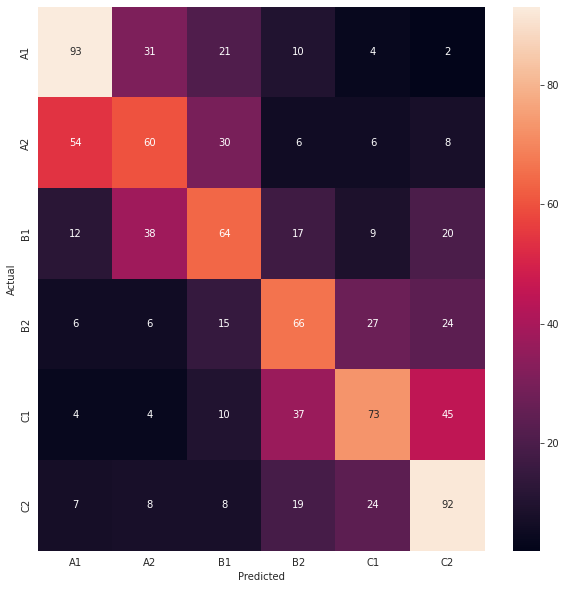

In [18]:
Accuracy_conf_mat(y_test, prediction)

Now, we can take observe some examples of sentences that are not correctly classified

In [19]:
Sentences_badly_classified(0,5, X_test,prediction, y_test)

("C'est en décembre 1967, après bien des invectives au Parlement, que sa loi relative à la régulation des naissances, dite loi Neuwirth est votée : elle autorise la vente exclusive des contraceptifs en pharmacie sur ordonnance médicale, avec autorisation parentale pour les mineures", 'has been classified as ', 'C2', 'and should be ', 'C1')
('Giscard va pourtant réussir à transformer ce revers en tremplin', 'has been classified as ', 'B2', 'and should be ', 'C1')
("Un choix difficile mais important : le public français écoute souvent les professionnels de Cannes pour choisir le film qu'il va aller voir au cinéma.", 'has been classified as ', 'B1', 'and should be ', 'A2')
("Le débat porte plutôt sur l'utilité d'une telle mesure.", 'has been classified as ', 'C1', 'and should be ', 'B1')


We can make our first predicition on the unlabelled data

In [20]:
prediction = Prediction(pipe, df_test['sentence'])

We take the opportunity to make our first csv file for the Kaggle submission

In [21]:
submission = submission(df_test['id'], prediction)
submission.to_csv('premiertestkaggle.csv', header=True, index=False)

#4.3. KNN (without data cleaning)
Train a KNN classification model using a Tfidf vectoriser. 


In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
knn = KNeighborsClassifier()
pipe_knn = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Fit model on training set
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', KNeighborsClassifier())])

Show the accuracy, precision, recall and F1 score on the test set.

In [24]:
prediction = Prediction(pipe_knn, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.3187
	Precision: 0.4030
	Recall: 0.3187
	F1_Score: 0.3022


Try to improve it by tuning the hyper parameters(n_neighbors, p, weights) with a GridSearchCV.

In [25]:
from sklearn.model_selection import GridSearchCV

knn_grid = {'n_neighbors' : np.arange(start=1, stop=10, step=1),
            'p': np.arange(1,3),
            'weights' : ['uniform', 'distance']}
knn_cv = GridSearchCV(knn, knn_grid, cv = 5)
pipe_grid_knn = Pipeline([('vectorizer', tfidf_vector), ('knn_cv', knn_cv)])

pipe_grid_knn.fit(X_train, y_train)
print('Best hyperparameters:', knn_cv.best_params_)

Best hyperparameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


We have found the best Knn model with these parameter. We can try it!

In [26]:
knn2 = KNeighborsClassifier(n_neighbors=4, p = 2, weights = 'distance')
pipe_knn_2 = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', knn2)])
pipe_knn_2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

Show the accuracy, precision, recall and F1 score on the test set.

In [27]:
prediction = Prediction(pipe_knn_2 , X_test)
Evaluate(y_test,prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.3677
	Precision: 0.4242
	Recall: 0.3677
	F1_Score: 0.3571


#4.4. Decision Tree Classifier (without data cleaning)
Train a Decison Tree classifier, using a Tfidf vectoriser.

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
#Choose random state of 0 arbitrarly to don't have fluctuations in my values
dec = DecisionTreeClassifier(random_state = 0)
pipe_dec = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', dec)])
# Fit model on training set
pipe_dec.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

Show the accuracy, precision, recall and F1 score on the test set.

In [30]:
prediction = Prediction(pipe_dec, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.2969
	Precision: 0.3004
	Recall: 0.2969
	F1_Score: 0.2952


Try to improve it by tuning the hyper parameters (max_depth, the depth of the decision tree).

In [31]:
dec_grid = {'max_depth': np.arange(5,25, 1)}

dec_CV = GridSearchCV(dec, dec_grid , cv = 5)

pipe_grid_dec = Pipeline([('vectorizer', TfidfVectorizer()), ('dec', dec_CV)])

pipe_grid_dec.fit(X_train, y_train)
pred = pipe_grid_dec.predict(X_test)

print("Hyperparameters:", dec_CV.best_params_)

Hyperparameters: {'max_depth': 16}


We have found the best DecisionTreeClassifier model with these parameters. We can try it!

In [32]:
dec2 = DecisionTreeClassifier(max_depth=16, random_state = 0)

pipe_dec_2= Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', dec2)])
# Fit model on training set
pipe_dec_2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=16, random_state=0))])

Show the accuracy, precision, recall and F1 score on the test set.

In [33]:
prediction = Prediction(pipe_dec_2, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.3156
	Precision: 0.3158
	Recall: 0.3156
	F1_Score: 0.3008


#4.5. Random Forest Classifier (without data cleaning)

Try a Random Forest Classifier, using a Tfidf vectoriser.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
Rdc = RandomForestClassifier()

pipe_RDC = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', Rdc)])

# Fit model on training set
pipe_RDC.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

Show the accuracy, precision, recall and F1 score on the test set.

In [36]:
prediction = Prediction(pipe_dec_2, X_test)
Evaluate(y_test, prediction)

CLASSIFICATION REPORT:
	Accuracy: 0.3156
	Precision: 0.3158
	Recall: 0.3156
	F1_Score: 0.3008
